In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
import scikit_posthocs as sp
from scipy.stats import kruskal
from sklearn.utils import resample
from sklearn.feature_selection import RFE
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

pd.set_option('display.max_columns', None)  # Отображение всех столбцов
# pd.set_option('display.max_rows', None)  # Ото----бражение всех строк   
regions = pd.read_csv('regions.csv')
starts = pd.read_csv('starts.csv')
volunteers = pd.read_csv('volunteers.csv')



volunteers = volunteers[volunteers.athlete_age < 100]
starts = starts[starts.athlete_age < 80]
starts = starts[starts.finish_time < 5000]

starts['rain.1h'] = starts['rain.1h'].fillna(0)
starts['snow.1h'] = starts['snow.1h'].fillna(0)

cnt_ludei = starts.groupby(['event_name', 'event_date', 'region']).agg(
    cnt_runners = ('athlete_id', 'count')
)


young_volunteers = volunteers[volunteers['athlete_age'] <= 14]

starts = starts.merge(young_volunteers[['event_name', 'event_date', 'athlete_id']], 
                      on=['event_name', 'event_date'], 
                        how='left',
                      suffixes=('', '_vol'))

starts['has_young_volunteers'] = starts['athlete_id_vol'].notna()
starts['has_young_volunteers'] =starts['has_young_volunteers'].astype(int)
starts = starts.drop(columns=['athlete_id_vol'], axis=1)





ages_14 = starts[starts['athlete_age'] == 14]['athlete_id'].unique()
ages_15 = starts[starts['athlete_age'] == 15]['athlete_id'].unique()
common_athletes = set(ages_14) & set(ages_15)
starts = starts[~starts['athlete_id'].isin(common_athletes)]



starts['is_male'] = starts['athlete_gender'].apply(lambda x: 1 if x == 'мужской' else 0)
starts = starts[starts['athlete_age'] > 14]

volunteer_counts = volunteers.groupby(['event_date','event_name', 'volunteer_role_name']).size().unstack(fill_value=0)  
starts = starts.merge(volunteer_counts, on=['event_date','event_name'], how='left')  

starts = starts.dropna(subset=[col for col in starts.columns if col not in ['snow.1h', 'rain.1h']])   # удаление где 0 волонтеров в сумме было


unique_dates = (
    pd.concat([
        starts[['athlete_id', 'event_date']],
        volunteers[['athlete_id', 'event_date']]
    ])
    .drop_duplicates()
)
date_counts = unique_dates.groupby('athlete_id').size().reset_index(name='unique_event_count')
date_counts['is_repeated'] = (date_counts['unique_event_count'] > 1).astype(int)
starts = starts.merge(date_counts[['athlete_id', 'is_repeated']], on='athlete_id', how='left')


# starts = starts[~starts['region'].isin(['Республика Адыгея', 'Республика Карелия', 'Липецкая область', 'Сахалинская область', 'Архангельская область'])]  
starts = starts[starts.event_date <= '2023-10-15']


newbie = starts[starts['is_newbie'] == 1]
first_runs = newbie.sort_values(by='event_date').drop_duplicates('athlete_id')
didnt_come = first_runs[first_runs.is_repeated == 0]

come = first_runs[first_runs.is_repeated == 1]
come_with_didnt_come = pd.concat([come, didnt_come])
come_with_didnt_come['cnt_volunteers'] = come_with_didnt_come.iloc[:, 25:52].sum(axis=1)
come_with_didnt_come = come_with_didnt_come.merge(cnt_ludei,on=['event_name', 'event_date', 'region'], how="left")
print(len(come_with_didnt_come))

16708


# Общий катбуст

In [2]:
from catboost import CatBoostClassifier, Pool  
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



X = come_with_didnt_come.drop(columns=['is_repeated', 'athlete_id', 'record_id', 'event_name', 'event_date', 'region', 'city', 'is_newbie', 
   # 'athlete_gender', 'weather.main','weather.description','track_description_surface',
 #   'dew_point',
    'is_male',
    'cnt_volunteers',
    #'humidity','finish_time', 'athlete_age', 'athlete_gender', 'wind_speed', 'feels_like', 
    #'pressure', 'temp', 
    # 'snow.1h', 'rain.1h', 'weather.main', 'weather.description', 'track_description_surface', 'wind_deg', 'clouds', 
    #'cnt_runners'
], axis=1)  
y = come_with_didnt_come['is_repeated']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 
categorical_cols = ['athlete_gender', 'weather.main', 'weather.description', 'track_description_surface']

model = CatBoostClassifier(iterations=1000, depth=4, learning_rate=0.1,verbose=0  ,cat_features=categorical_cols)  
print('катбуст начальный со всеми переменными')
model.fit(X, y)  


preds = model.predict(X_test)  
cm = confusion_matrix(y_test, preds)
print(cm)
print(f'Accuracy: {accuracy_score(y_test, preds):.2f}') 




feature_importances = model.get_feature_importance()  
importance_df = pd.DataFrame({  
    'Feature': X.columns,  # Используйте реальные имена признаков  
    'Importance': feature_importances  
})  

# Сортировка значений важности в порядке убывания  
importance_df = importance_df.sort_values(by='Importance', ascending=False)  

display(importance_df)


катбуст начальный со всеми переменными
[[417 331]
 [151 772]]
Accuracy: 0.71


,Feature,Importance
2,athlete_age,11.513688
0,finish_time,10.882341
44,cnt_runners,8.617707
9,wind_speed,6.232879
38,Сканирование штрих-кодов,5.454182
3,temp,5.410655
7,dew_point,5.198736
10,wind_deg,5.087613
5,pressure,4.866334
6,humidity,4.584611


# Модель по 1 кластеру (2-46 участников) СО СТАНДАРТИЗАЦИЕЙ И RFE (ТОП-15 признаков)

In [2]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed',
                 'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
                'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования', 
                'cnt_runners']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=15)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'Завершение мероприятия', 'Инструктаж новых участников', 'Организатор', 'Пейсер', 'Раздача карточек позиций', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners']
Optimization terminated successfully.
         Current function value: 0.658505
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8113
Model:                          Logit   Df Residuals:                     8097
Method:                           MLE   Df Model:                           15
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02690
Time:                        20:55:32   Log-Likelihood:                -5342.5
converged:        

In [21]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Список всех колонок, которые будут использоваться для модели
need_columns = [
    'finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed',
    'Ведущий велосипед', 'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 
    'Обработка результатов', 'Организатор', 'Организация финиша', 'Пейсер', 'Подготовка мероприятия',
    'Помощь в раздаче карточек позиций', 'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы',
    'Раздача карточек позиций', 'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов',
    'Сортировка карточек', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners'
]

# Задаем фиксированные признаки, которые не должны исключаться
fixed_features = ['Пейсер', 'Маршал', 'Сканирование штрих-кодов', 'Раздача карточек позиций', 'Инструктаж новых участников', 'Замыкающий']

# Отбор данных
X = come_with_didnt_come[
    (come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)
][need_columns]
y = come_with_didnt_come.loc[
    (come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46),
    'is_repeated'  # Название целевой переменной
]

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except Exception as e:
                print(f'Ошибка в проверке корреляции между {col1} и {col2}: {e}')

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# RFE для отбора признаков
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')

# Исключаем фиксированные признаки из отбора
X_rfe_input = X_scaled.drop(columns=fixed_features)
rfe = RFE(logit_model, n_features_to_select=15 - len(fixed_features))
rfe.fit(X_rfe_input, y)

# Выбранные признаки из RFE
rfe_selected_features = list(X_rfe_input.columns[rfe.support_])

# Объединяем с фиксированными признаками
final_features = fixed_features + rfe_selected_features
print("Финальные выбранные признаки после RFE:", final_features)

# Создаем DataFrame с отобранными признаками
X_selected = X_scaled[final_features]

# Добавляем константу для statsmodels
X_selected = sm.add_constant(X_selected)

# Обучение модели с выбранными признаками
model = sm.Logit(y, X_selected).fit()
print('\nМодель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей\n')
print(model.summary())
# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(X_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Финальные выбранные признаки после RFE: ['Пейсер', 'Маршал', 'Сканирование штрих-кодов', 'Раздача карточек позиций', 'Инструктаж новых участников', 'Замыкающий', 'finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'Завершение мероприятия', 'Сортировка карточек', 'Хранение и доставка оборудования', 'cnt_runners']
Optimization terminated successfully.
         Current function value: 0.658668
         Iterations 5

Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей

                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8113
Model:                          Logit   Df Residuals:                     8097
Method:                           MLE   Df Model:                           15
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02666
Time:                        21:31:54   Log-Likelihood:                -5343.8
converged:   

In [ ]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 2) & (come_with_didnt_come.cnt_runners <= 46)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=15)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed']
Optimization terminated successfully.
         Current function value: 0.660854
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 8113
Model:                          Logit   Df Residuals:                     8106
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02343
Time:                        21:19:26   Log-Likelihood:                -5361.5
converged:                       True   LL-Null:                       -5490.1
Covariance Type:            nonrobust   LLR p-value:                 1.148e-52
                  coef    std err          z      P>|z|      [0.025   

c:\Users\Semyon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=15 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(


# Модель по 2 кластеру (47-138 участников) СО СТАНДАРТИЗАЦИЕЙ И RFE (ТОП-15 признаков)

In [4]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed',
                 'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
                'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования', 
                'cnt_runners']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=15)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'humidity', 'Ведущий велосипед', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Помощь в раздаче карточек позиций', 'Проверка трассы', 'Раздача карточек позиций', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Хранение и доставка оборудования']
Optimization terminated successfully.
         Current function value: 0.674114
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5836
Model:                          Logit   Df Residuals:                     5820
Method:                           MLE   Df Model:                           15
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.02027
Time:                        13:37:16   Log-Likelihood:               

In [22]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Список всех колонок, которые будут использоваться для модели
need_columns = [
    'finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed',
    'Ведущий велосипед', 'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 
    'Обработка результатов', 'Организатор', 'Организация финиша', 'Пейсер', 'Подготовка мероприятия',
    'Помощь в раздаче карточек позиций', 'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы',
    'Раздача карточек позиций', 'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов',
    'Сортировка карточек', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners' 
]

# Задаем фиксированные признаки, которые не должны исключаться
fixed_features = ['Пейсер', 'Маршал', 'Сканирование штрих-кодов', 'Раздача карточек позиций', 'Инструктаж новых участников', 'Замыкающий']

# Отбор данных
X = come_with_didnt_come[
    (come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)
][need_columns]
y = come_with_didnt_come.loc[
    (come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138),
    'is_repeated'  # Название целевой переменной
]

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except Exception as e:
                print(f'Ошибка в проверке корреляции между {col1} и {col2}: {e}')

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# RFE для отбора признаков
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')

# Исключаем фиксированные признаки из отбора
X_rfe_input = X_scaled.drop(columns=fixed_features)
rfe = RFE(logit_model, n_features_to_select=15 - len(fixed_features))
rfe.fit(X_rfe_input, y)

# Выбранные признаки из RFE
rfe_selected_features = list(X_rfe_input.columns[rfe.support_])

# Объединяем с фиксированными признаками
final_features = fixed_features + rfe_selected_features
print("Финальные выбранные признаки после RFE:", final_features)

# Создаем DataFrame с отобранными признаками
X_selected = X_scaled[final_features]

# Добавляем константу для statsmodels
X_selected = sm.add_constant(X_selected)

# Обучение модели с выбранными признаками
model = sm.Logit(y, X_selected).fit()
print('\nМодель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей\n')
print(model.summary())
# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(X_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Финальные выбранные признаки после RFE: ['Пейсер', 'Маршал', 'Сканирование штрих-кодов', 'Раздача карточек позиций', 'Инструктаж новых участников', 'Замыкающий', 'finish_time', 'athlete_age', 'feels_like', 'humidity', 'Ведущий велосипед', 'Завершение мероприятия', 'Проверка трассы', 'Секундомер', 'Хранение и доставка оборудования']
Optimization terminated successfully.
         Current function value: 0.674413
         Iterations 4

Модель для предсказывания is_repeated новичка, в пробежках где было 2-46 людей

                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5836
Model:                          Logit   Df Residuals:                     5820
Method:                           MLE   Df Model:                           15
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.01984
Time:                        21:32:23   Log-Likelihood:                -3935.9
converged

In [25]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 47) & (come_with_didnt_come.cnt_runners <= 138)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=15)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed']
Optimization terminated successfully.
         Current function value: 0.679986
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 47-138 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 5836
Model:                          Logit   Df Residuals:                     5829
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.01174
Time:                        21:40:26   Log-Likelihood:                -3968.4
converged:                       True   LL-Null:                       -4015.5
Covariance Type:            nonrobust   LLR p-value:                 3.915e-18
                  coef    std err          z      P>|z|      [0.025 

c:\Users\Semyon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=15 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(


# Модель по 2 кластеру (139-404 участников) СО СТАНДАРТИЗАЦИЕЙ И RFE (ТОП-15 признаков)

In [5]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 405)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 405)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed',
                 'Ведущий велосипед', 
                'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 'Обработка результатов', 'Организатор',
                'Организация финиша', 'Пейсер', 'Подготовка мероприятия', 'Помощь в раздаче карточек позиций',
                'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы', 'Раздача карточек позиций',
                'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек',
                'Фотограф', 'Хранение и доставка оборудования', 
                'cnt_runners']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=15)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'pressure', 'humidity', 'Организация финиша', 'Проверка трассы', 'Раздача карточек позиций', 'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов', 'Сортировка карточек', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners']
Optimization terminated successfully.
         Current function value: 0.652906
         Iterations 5


Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1865
Model:                          Logit   Df Residuals:                     1849
Method:                           MLE   Df Model:                           15
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.05782
Time:                        13:38:34   Log-Likelihood:                -1217.7
converged:         

In [24]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Список всех колонок, которые будут использоваться для модели
need_columns = [
    'finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed',
    'Ведущий велосипед', 'Завершение мероприятия', 'Замыкающий', 'Инструктаж новых участников', 'Маршал', 
    'Обработка результатов', 'Организатор', 'Организация финиша', 'Пейсер', 'Подготовка мероприятия',
    'Помощь в раздаче карточек позиций', 'Проведение разминки', 'Проверка карточек позиций', 'Проверка трассы',
    'Раздача карточек позиций', 'Разное', 'Связи с общественностью', 'Секундомер', 'Сканирование штрих-кодов',
    'Сортировка карточек', 'Фотограф', 'Хранение и доставка оборудования', 'cnt_runners' 
]

# Задаем фиксированные признаки, которые не должны исключаться
fixed_features = ['Пейсер', 'Маршал', 'Сканирование штрих-кодов', 'Раздача карточек позиций', 'Инструктаж новых участников', 'Замыкающий']

# Отбор данных
X = come_with_didnt_come[
    (come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)
][need_columns]
y = come_with_didnt_come.loc[
    (come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404),
    'is_repeated'  # Название целевой переменной
]

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except Exception as e:
                print(f'Ошибка в проверке корреляции между {col1} и {col2}: {e}')

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# RFE для отбора признаков
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')

# Исключаем фиксированные признаки из отбора
X_rfe_input = X_scaled.drop(columns=fixed_features)
rfe = RFE(logit_model, n_features_to_select=15 - len(fixed_features))
rfe.fit(X_rfe_input, y)

# Выбранные признаки из RFE
rfe_selected_features = list(X_rfe_input.columns[rfe.support_])

# Объединяем с фиксированными признаками
final_features = fixed_features + rfe_selected_features
print("Финальные выбранные признаки после RFE:", final_features)

# Создаем DataFrame с отобранными признаками
X_selected = X_scaled[final_features]

# Добавляем константу для statsmodels
X_selected = sm.add_constant(X_selected)

# Обучение модели с выбранными признаками
model = sm.Logit(y, X_selected).fit()
print('\nМодель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей\n')
print(model.summary())
# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(X_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Финальные выбранные признаки после RFE: ['Пейсер', 'Маршал', 'Сканирование штрих-кодов', 'Раздача карточек позиций', 'Инструктаж новых участников', 'Замыкающий', 'finish_time', 'athlete_age', 'Обработка результатов', 'Подготовка мероприятия', 'Проверка трассы', 'Секундомер', 'Сортировка карточек', 'Хранение и доставка оборудования', 'cnt_runners']
Optimization terminated successfully.
         Current function value: 0.654490
         Iterations 5

Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей

                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1865
Model:                          Logit   Df Residuals:                     1849
Method:                           MLE   Df Model:                           15
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.05553
Time:                        21:33:24   Log-Likelihood:              

In [26]:
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Отбор данных
X = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)]
y = come_with_didnt_come[(come_with_didnt_come.cnt_runners >= 139) & (come_with_didnt_come.cnt_runners <= 404)]

need_columns = ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed']

# Проверка на мультиколлинеарность
for col1 in need_columns:
    for col2 in need_columns:
        if col1 != col2:
            try:
                coef = X[col1].corr(X[col2], method='spearman')
                if abs(coef) > 0.8:
                    print('Возможна мультиколлинеарность: ', coef, col1, col2)
            except:
                print('Ошибка в цикле на проверке корреляций между', col1, col2)

# Подготовка данных
for_model = X[need_columns]
y = y['is_repeated']

# Стандартизация данных с сохранением названий колонок
scaler = StandardScaler()
for_model_scaled = pd.DataFrame(scaler.fit_transform(for_model), columns=for_model.columns, index=for_model.index)

# RFE для отбора признаков (используем масштабированные данные)
logit_model = LogisticRegression(max_iter=10000, solver='lbfgs')
rfe = RFE(logit_model, n_features_to_select=15)
rfe.fit(for_model_scaled, y)

# Выбранные признаки
selected_features = for_model_scaled.columns[rfe.support_]
print("Выбранные признаки после RFE:", selected_features.tolist())

# Создаем DataFrame с отобранными признаками
for_model_selected = for_model_scaled[selected_features]

# Добавляем константу для statsmodels
for_model_selected = sm.add_constant(for_model_selected)

model = sm.Logit(y, for_model_selected).fit()
print('\n')
print('Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей')
print('\n')
print(model.summary())

# Предельные эффекты
marginal_effects = model.get_margeff()
print('\n')
print('Предельные эффекты:')
print(marginal_effects.summary())
print('\n')

# Оценка точности
y_pred = model.predict(for_model_selected)
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:\n", cm)
accuracy = (y_pred_class == y).mean()
print(f'Accuracy: {accuracy:.2f}')


Выбранные признаки после RFE: ['finish_time', 'athlete_age', 'feels_like', 'pressure', 'humidity', 'wind_speed']
Optimization terminated successfully.
         Current function value: 0.672074
         Iterations 4


Модель для предсказывания is_repeated новичка, в пробежках где было 139-404 людей


                           Logit Regression Results                           
Dep. Variable:            is_repeated   No. Observations:                 1865
Model:                          Logit   Df Residuals:                     1858
Method:                           MLE   Df Model:                            6
Date:                Tue, 10 Dec 2024   Pseudo R-squ.:                 0.03016
Time:                        21:41:16   Log-Likelihood:                -1253.4
converged:                       True   LL-Null:                       -1292.4
Covariance Type:            nonrobust   LLR p-value:                 9.481e-15
                  coef    std err          z      P>|z|      [0.025

c:\Users\Semyon\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py:291: UserWarning: Found n_features_to_select=15 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(


Log-likelihoods.
1 группа:
С волонтерами = -5343.8; Только с контролем = -5361.5
2 группа:
С волонтерами = -3935.9 ; Только с контролем = -3968.4
3 группа:
С волонтерами = -1220.6; Только с контролем = -1253.4

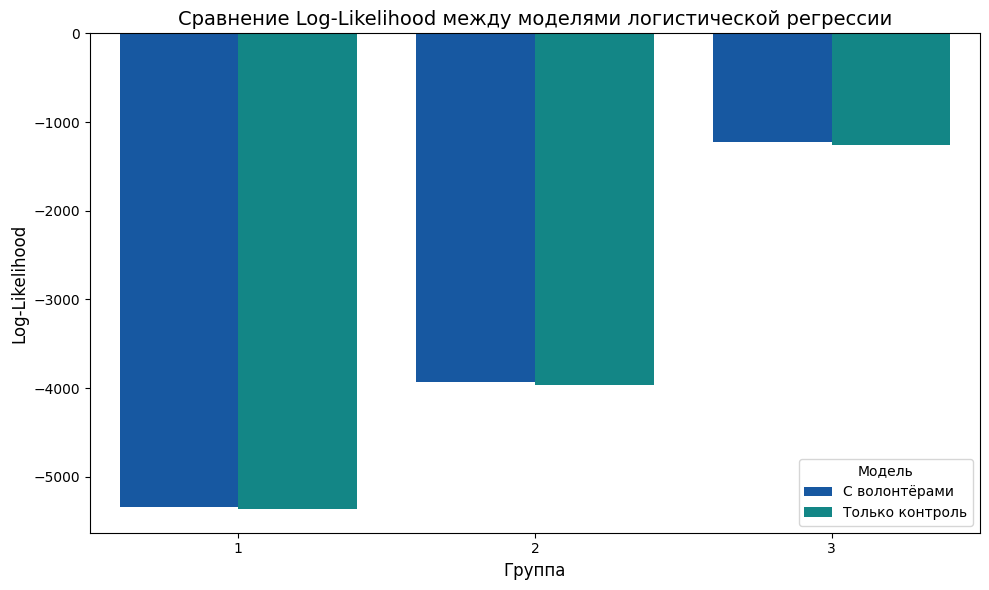

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Данные
data = {
    'Группа': ['1', '1', '2', '2', '3', '3'],
    'Модель': ['С волонтёрами', 'Только контроль', 'С волонтёрами', 'Только контроль', 'С волонтёрами', 'Только контроль'],
    'Log-Likelihood': [-5343.8, -5361.5, -3935.9, -3968.4, -1220.6, -1253.4]
}

df = pd.DataFrame(data)

# Фирменные цвета компании «5 вёрст»
colors = ['#0057B8', '#009999']  # Синий и сине-зелёный

# Создание графика
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Группа', y='Log-Likelihood', hue='Модель', palette=colors)
plt.title('Сравнение Log-Likelihood между моделями логистической регрессии', fontsize=14)
plt.xlabel('Группа', fontsize=12)
plt.ylabel('Log-Likelihood', fontsize=12)
plt.legend(title='Модель')
plt.tight_layout()
plt.show()
